# $$Build\ a\ Linear\ Regression\ Pipeline$$

## 1. Load libraries

In [1]:
import json

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from datamodel_code_generator import InputFileType, generate
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## 2. Load sample dataset

In [2]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

Rename columns for convenience.

In [3]:
X.columns = X.columns.str.strip().str.lower()
y.name = y.name.strip().lower()

And split the data into train and test sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7
)

## 3. Data analysis
Check the distribution of all variables.

In [5]:
pd.concat([X_train, y_train], axis=1).describe()

,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude,medhouseval
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.00000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.857212,28.651421,5.434270,1.099695,1427.65801,3.032784,35.643345,-119.578469,2.060858
std,1.895595,12.561114,2.643625,0.518068,1148.24416,6.634165,2.140187,2.005156,1.153684
min,0.499900,1.000000,0.846154,0.333333,3.00000,0.750000,32.540000,-124.350000,0.149990
25%,2.555175,18.000000,4.431049,1.005523,788.00000,2.432108,33.940000,-121.810000,1.188000
50%,3.517900,29.000000,5.220048,1.048497,1166.00000,2.817800,34.260000,-118.500000,1.789500
75%,4.733300,37.000000,6.041337,1.099455,1729.00000,3.284245,37.720000,-118.010000,2.625000
max,15.000100,52.000000,141.909091,34.066667,35682.00000,599.714286,41.950000,-114.310000,5.000010


Wow, some upper and lower extreme values seem unbelieveable if this is a housing dataset (an area with houses of 141 rooms on average!?!?), but unfortunately digging deeper is out of the scope of this analysis.

In [6]:
X_train.corrwith(y_train)

medinc        0.690340
houseage      0.096457
averooms      0.140480
avebedrms    -0.046104
population   -0.022627
aveoccup     -0.032573
latitude     -0.143095
longitude    -0.046897
dtype: float64

No strong linear correlation with Median House Value (``medinc``) apart from of Median Income (``medhouseval``), lets take that and Average Number of Rooms (``averooms``).

In [7]:
input_vars = ["medinc", "averooms"]

## 5. ML Modeling
We are going to build a pipeline consisting of a transformation step (standardization) and training a linear regression model. The pipeline is stored for later inference.

In [8]:
reg_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LinearRegression())]
)
reg_pipeline.fit(X_train[input_vars], y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [9]:
y_pred = reg_pipeline.predict(X_test[input_vars])

A quick plot.

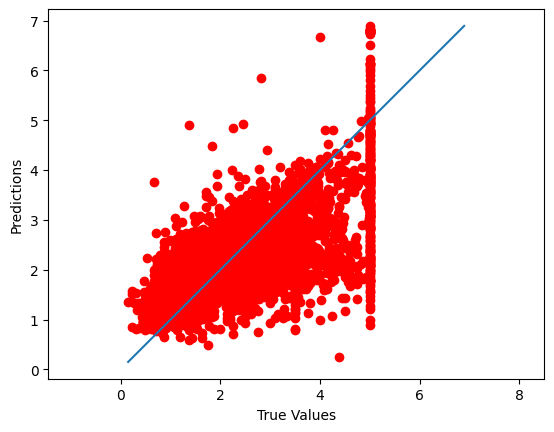

In [10]:
plt.figure()
plt.scatter(y_test, y_pred, c="red")
ymax = max(max(y_pred), max(y_test))
ymin = min(min(y_pred), min(y_test))
plt.plot([ymax, ymin], [ymax, ymin])
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.axis("equal")
plt.show()

Looks like a poor performing model! But lets store it for inference.

In [11]:
joblib.dump(reg_pipeline, "../app/data/ml_model.joblib")

['../app/data/ml_model.joblib']

## 6. Testing and monitoring
Create a test dataset (not out-of-sample required) for API testing and monitoring. 

In [12]:
test_data = (
    pd.concat([X_train[input_vars], y_train], axis=1)
    .sample(n=10000, random_state=7)
    .reset_index(drop=True)
)
test_data["y_pred"] = reg_pipeline.predict(test_data[input_vars])
test_data.to_json("../app/data/test_data.json", orient="records")

Create a sample url form for

In [13]:
request_string = "&".join(
        [str(k) + "=" + str(v) for k, v in dict(test_data.loc[0,input_vars]).items()]
    )
text_file = open("../app/data/sample_url_params.txt", "w")
n = text_file.write('''"''' + request_string + '''"''')
text_file.close()

Define the variable characteristics in ```set_vars``` according to:
https://koxudaxi.github.io/datamodel-code-generator/support-data-types/

In [14]:
set_vars = {
    "medinc": {"type": "number", "minimum": 0, "maximum": 50},
    "averooms": {"type": "number", "minimum": 0, "maximum": 150},
}

Generate a pydantic data model for predictions in fastAPI.

In [15]:
generate(
    str(
        {
            "type": "object",
            "title": "PredictModel",
            "properties": set_vars,
            "required": input_vars,
        }
    ),
    input_file_type=InputFileType.JsonSchema,
    output=Path("../app/data/pydantic_model.py"),
)